In [1]:
# import sys
# sys.path.append('../')
from utils import *
# from objectnet_test import *
from torch.nn.functional import relu
seed = 1
import matplotlib.pyplot as plt
set_seed(seed)
torch.set_default_dtype(torch.float32)

import pytorch_lightning as pl
from datamodules import WaterbirdsDataModule, ImageNet9DataModule
from lightning_modules import *
from inspect_utils import *
from torchvision.models import vit_b_16, resnet50
from torchvision.datasets import CIFAR100, ImageNet
from torchvision import transforms
import pickle
import torch.nn.functional as F
from torch.nn.utils.parametrizations import orthogonal
from itertools import chain
from functools import partial

from livelossplot import PlotLosses


In [2]:
def my_getattr(m, x, y=None):
    xis = x.split('.')
    t = m
    for xi in xis:
        if xi.isnumeric():
            t = t[int(xi)]
        else:
            t = getattr(t, xi, y)
    return t

In [2]:
num_workers = 4*torch.cuda.device_count()
gpu_size = 512*torch.cuda.device_count()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
data_module = ImageNet9DataModule(get_masks=True)
data_module.setup()
batch_size = max(gpu_size, 100)
fg_loader = data_module.onlyfg_dataset.make_loaders(num_workers, batch_size, mode='val', shuffle_val=False)
bg_loader = data_module.nofg_dataset.make_loaders(num_workers, batch_size, mode='val', shuffle_val=False)


==> Preparing dataset ImageNet9..
==> Preparing dataset ImageNet9..


In [5]:
activation = {}

def read_output(inp, out, name):
    if isinstance(out, tuple):
        activation[name] = out[0].detach()#.cpu()
    else:
        activation[name] = out.detach()#.cpu()
    if name == 'encoder' or name == 'norm':
        activation[name] = activation[name][:,0:1]
    return

def modify_output(inp, out, name, orig_acts_dict, weights_param, bases_module):
    if orig_acts_dict[name] is None:
#         print('a')
        return out
#     print('b')
    orig_acts = orig_acts_dict[name]
    bases = bases_module.weight
    weights = torch.sigmoid(weights_param)
    m_out = (bases.T@((weights*(bases_module(orig_acts)) 
                +(1 - weights)*(bases_module(out)) ).unsqueeze(-1))).squeeze()
#     m_out = orig_acts
    return m_out

def get_hook(name, read_fn, modify_fn=None):
    # the hook signature
    def hook(model, input, output):
        read_fn(input, output, name)
        if modify_fn is not None:
            output = modify_fn(input, output, name)
#             read_fn(input, output, name+"_after")
            return output
    return hook

In [3]:
lightning_model = ImageNet9Predictor.load_from_checkpoint('./models/imagenet9/mtype-deit_b_16_num_classes-9_lr-1e-05_weight_decay-1e-06/epoch=01-step=1200-orig_val_acc=0.99.ckpt')
model = lightning_model.model.to(device)
normalizer = lightning_model.normalizer

==>[Loaded PyTorch-pretrained deit checkpoint.]


In [7]:
model


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_featu

In [7]:
def setup_params(model, normalizer, weight_init, dataloader, store_dict, hook_names, per_token=False, use_bases=False):
    all_handles = []
    for hook_name in hook_names:
        handle = my_getattr(model, hook_name).register_forward_hook(get_hook(hook_name, read_output))
        all_handles.append(handle)
    
    weights_param = dict()
    bases_modules = dict()
    
    for imgs, masks, labels in dataloader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        masks = masks[:,0:1]
        with torch.no_grad():
            orig_logits = model(normalizer(imgs)).cpu()
        for hook_name in hook_names:
            act = store_dict[hook_name]
            n, l, b = act.shape
            weights_param[hook_name] = torch.full((1, l if per_token else 1, b), weight_init, requires_grad=True, device=device)
            bases_params = torch.nn.Linear(b, b, bias=False).to(device)
            torch.nn.init.eye_(bases_params.weight)
            if use_bases:   
                bases_modules[hook_name] = orthogonal(bases_params, orthogonal_map=None)
            else:
                bases_params.weight.requires_grad_(False)
                bases_modules[hook_name] =bases_params
        break
        
    for handle in all_handles:
        handle.remove()
    all_handles = []  
    return weights_param, bases_modules

def find_causal_neurons(model, normalizer, dataloader, store_dict, label_names, hook_names, hyperparams,
                        weights_param=None, weight_init=0, bases_modules=None,
                        per_token=False, use_bases=False, mask_type='lm', flip=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    _ = model.eval()
    for p in model.parameters():
        p.requires_grad_(False)
        
    if weights_param is None:
        weights_param, bases_modules = setup_params(model, normalizer, weight_init, dataloader, store_dict, hook_names, per_token, use_bases)
    
    all_parameters = [weights_param.values()]
    if use_bases:
        all_parameters += [module.parameters() for module in bases_modules.values()]
    all_parameters = chain(*all_parameters)
    opt = torch.optim.AdamW(all_parameters, lr=hyperparams['lr'], betas=hyperparams['betas'])
#     opt = torch.optim.SGD(all_parameters, lr=hyperparams['lr'])
    orig_acts_dict = dict([(name, None) for name in hook_names])
    for hook_name in hook_names:
        modify_fn = partial(modify_output, orig_acts_dict=orig_acts_dict, 
                                           weights_param=weights_param[hook_name], 
                                           bases_module=bases_modules[hook_name])
        my_getattr(model, hook_name).register_forward_hook(get_hook(hook_name, read_output, modify_fn=modify_fn))
        
    liveloss = PlotLosses()
    for e in range(hyperparams['epochs']):
        for i, (imgs, masks, labels) in enumerate(dataloader):
            print(f'Start {i}')
            
            imgs = imgs.to(device)
            masks = masks.to(device)
            masks = masks[:,0:1]
            
            
            # get original logits
            for hook_name in hook_names:
                orig_acts_dict[hook_name] = None
            orig_logits = model(normalizer(imgs)).cpu().detach()
            for hook_name in hook_names:
                orig_acts_dict[hook_name] = store_dict[hook_name]
            print(len(imgs), len(orig_acts_dict[hook_name]))

            # get masked logits
            if flip:
                masks = 1-masks
            if mask_type == 'lm':
                masked_imgs = (normalizer(imgs), masks, None)
            elif mask_type == 'greyout':
                masked_imgs = normalizer(imgs)*(masks)
            else:
                raise Exception('Mask type not defined')
            masked_logits = model(masked_imgs)
            
            # get loss and reg
            loss = F.relu(F.cross_entropy(masked_logits, labels.to(device)) - F.cross_entropy(orig_logits, labels).to(device))
            reg_vec = torch.cat([torch.sigmoid(w).reshape(-1) for w in weights_param.values()])
            reg = reg_vec.abs().mean()

            # optimize!
            total_loss = loss + hyperparams['lambda']*reg
            opt.zero_grad()
            total_loss.backward()
            opt.step()

            # send to live loss plot
            logs = {'loss': loss.detach().item(), 
                    'l1 reg': reg.detach().item(),
                    'clean acc': (orig_logits.argmax(-1).cpu() == labels).float().mean().item(),
                    'masked acc': (masked_logits.argmax(-1).cpu() == labels).float().mean().item(),
                    'total_loss': total_loss.detach().item(),
                   }
            liveloss.update(logs)
            liveloss.send()
        
    return weights_param, bases_modules

In [8]:
batch_size = 512
num_batches = 1
orig_loader = data_module.orig_dataset.make_loaders(num_workers,batch_size, mode='val', shuffle_val=True)
orig_loader_list = []
for i, (x, y, z) in enumerate(orig_loader):
    if i >= num_batches: break
    orig_loader_list.append((x,y,z))

==> Preparing dataset ImageNet9..


In [10]:
weights_param = None
bases_modules = None


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f1d303b59e0> (for post_execute):



KeyboardInterrupt



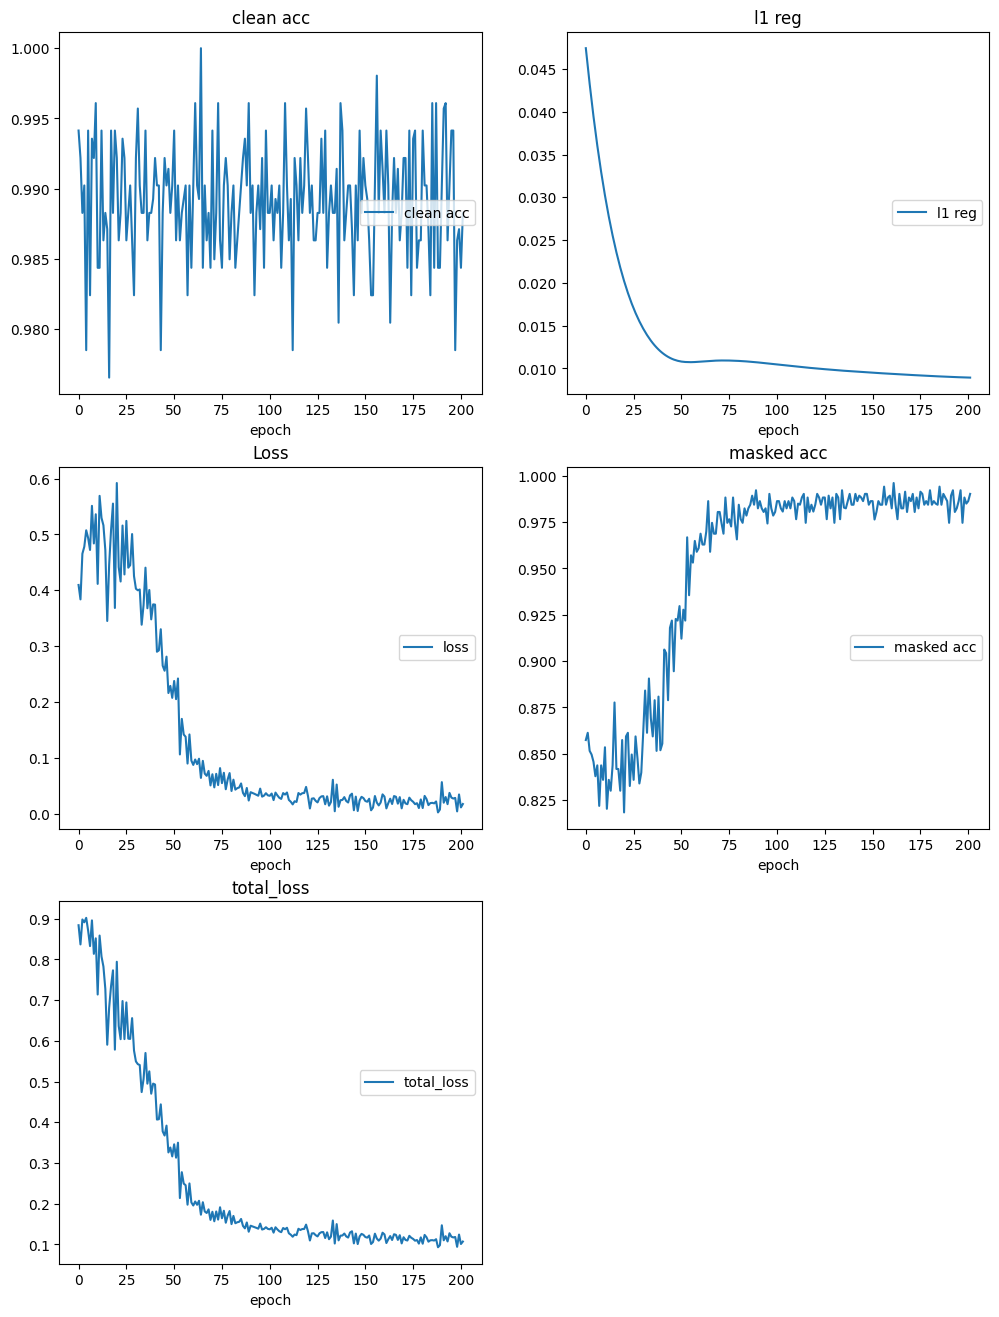

In [11]:
label_names = ['0_dog', '1_bird', '2_wheeled vehicle', '3_reptile', '4_carnivore', '5_insect', '6_musical instrument', '7_primate', '8_fish']
hook_names = ['norm']
hyperparams = {
                'lr':5e-2,
                'betas':(0.9, 0.999),
                'lambda': 10,
                'epochs':50,
                }

weights_param, bases_modules = find_causal_neurons(model, normalizer, orig_loader, activation, label_names, hook_names, hyperparams,
                                                   weights_param=weights_param, weight_init=-3., bases_modules=bases_modules,
                                                   per_token=True, use_bases=True, mask_type='greyout', flip=True)

In [12]:
plt.plot(torch.sigmoid(weights_param['norm']).squeeze().detach().cpu().numpy())

TypeError: 'NoneType' object is not subscriptable

In [33]:
(torch.sigmoid(weights_param['norm']).squeeze() >= 0.03).sum()

tensor(11, device='cuda:0')

Scratch

In [84]:
ind = 2
bg_logits, fg_logits = logits[ind][:,1,:], logits[ind][:,2,:]
rel_head =  model.head.weight[ind].detach()
ratios = (bg_logits.norm(dim=-1)*F.cosine_similarity(bg_logits, rel_head[None,:]))/(fg_logits.norm(dim=-1)*F.cosine_similarity(fg_logits, rel_head[None,:]))
ratios[ratios > -1].mean()

tensor(1.4473)

In [8]:
# with open('/cmlscratch/sriramb/deit_activations.pkl', 'wb') as fp:
#     pickle.dump((dict(all_acts), orig_hits, fg_hits, bg_hits, total), fp)
with open('/cmlscratch/sriramb/deit_activations.pkl', 'rb') as fp:
    all_acts, orig_hits, fg_hits, bg_hits, total = pickle.load(fp)
logits = all_acts['norm']
del all_acts



KeyboardInterrupt



In [7]:
# all_acts, orig_hits, fg_hits, bg_hits, total = get_intermediate_acts(model, normalizer, orig_loader, activation, label_names, mask_type='greyout')

In [14]:
np.array(orig_hits)/np.array(total), np.array(fg_hits)/np.array(total), np.array(bg_hits)/np.array(total)

(array([0.99777778, 0.98666667, 0.99333333, 0.98666667, 0.97777778,
        0.99333333, 0.99111111, 0.99333333, 0.98222222]),
 array([0.99333333, 0.98444444, 0.97777778, 0.95111111, 0.96666667,
        0.94888889, 0.94444444, 0.98444444, 0.94222222]),
 array([0.73777778, 0.83777778, 0.91333333, 0.75111111, 0.76888889,
        0.95777778, 0.93111111, 0.65111111, 0.89111111]))

In [10]:
def get_components(vecs, k, method='pca'):
    mean = vecs.mean(0, keepdims=True)
    if method == 'pca':
        eigvecs, eigvals = torch.lobpcg(torch.cov( (vecs-mean).transpose(0,1)), k=k)
    return torch.cat((means, eigvecs), dim=0)

tensor(-0.6394)

In [11]:
from functools import partial

def modify_output(inp, out, name, axes, inds, projections, mean_axes, mean_projections):
    m_out = out + (-torch.sum(out*mean_axes, dim=(-1,-2), keepdim=True) + mean_projections)*mean_axes
#     m_out_reshaped = m_out#.reshape(m_out.shape[0], -1)
    m_out = replace_axes(m_out, axes, inds, projections)
    return m_out

def replace_axes(x, axes, inds, projections):
    '''
    x: (n, l, d)
    axes: (n, k, d)
    inds: (n, k)
    projections: (n, k)
    '''
    n, l, d = x.shape
    k = inds.shape[1]
    if axes.shape[0]!= n:
        axes, inds, projections = axes.expand(n, -1, -1), inds.expand(n, -1), projections.expand(n, -1)
#     print(x.shape, axes.shape, inds.shape, projections.shape)
    for i in range(k):
        corr_proj = -torch.sum(x[torch.arange(n),inds[:,i]]*axes[:,i],dim=-1) + projections[:,i]
#         print(corr_proj, projections[:,i], torch.sum(x[torch.arange(n),inds[:,i]]*axes[:,i],dim=-1))
#         correction = torch.sum(axes*corr_proj.unsqueeze(-1), dim=1)
#         print(x[torch.arange(n),inds[:,i]].shape, corr_proj.shape, axes.shape)
        x[torch.arange(n),inds[:,i]] = x[torch.arange(n),inds[:,i]] + corr_proj[:,None]*axes[:,i]
    return x

Test cases

In [12]:
model = vit_b_16(pretrained=True).to(device)
for i, layer in enumerate(model.encoder.layers):
    if i <= 12:
        modify_fn = partial(modify_output, axes=all_axes[i], projections=all_clean_proj[i], inds=all_inds[i], mean_axes=mean_axes[i], mean_projections=mean_clean_proj[i])
        layer.register_forward_hook(get_hook(f"layer{i}", read_output, modify_fn=modify_fn))
    else:
        layer.register_forward_hook(get_hook(f"layer{i}", read_output))
_=model.encoder.register_forward_hook(get_hook(f"encoder", read_output))

In [13]:
new_clean_activations, new_corr_activations = get_intermediate_acts(model, activation, num_trials=5)

In [14]:
a = (((corr_activations[f'encoder'] - clean_activations[f'encoder'])))
b = (((new_corr_activations[f'encoder'] - new_clean_activations[f'encoder'])))
c = (((new_corr_activations[f'encoder'] - clean_activations[f'encoder'])))
d = (((new_clean_activations[f'encoder'] - clean_activations[f'encoder'])))

In [19]:
i = 10
print(((corr_activations[f'layer{i}'] - clean_activations[f'layer{i}'])[0]).abs().mean())
print(((new_corr_activations[f'layer{i}'] - clean_activations[f'layer{i}'])[0]).abs().mean())
print(((new_corr_activations[f'layer{i}_after'] - new_clean_activations[f'layer{i}_after'])[0]).abs().mean())

tensor(0.1967)
tensor(0.2814)


KeyError: 'layer10_after'

In [ ]:
new_diffs = [new_corr_activations[f'layer{i}'] - clean_activations[f'layer{i}'] for i in range(len(model.encoder.layers))]
new_diffs = torch.stack(new_diffs, dim=0)

In [ ]:
x = torch.randn(2, 3, 4)
axes = torch.zeros(2, 5, 4)
axes[:,0,0] = 1
axes[:,1,0] = 1
axes[:,2,1] = 1
axes[:,3,2] = 1
axes[:,4,3] = 1 
inds = torch.zeros(2, 5, dtype=torch.long)
inds[0,:] = torch.Tensor([0,1,2,0,1]) 
inds[1,:] = torch.Tensor([1,2,0,0,1]) 
projections = torch.zeros(2, 5)
# new_x = replace_axes(x, axes, inds, projections)
n, l, d = x.shape
k = inds.shape[1]
for i in range(k):
    corr_proj = -torch.sum(x[torch.arange(n),inds[:,i]]*axes[:,i],dim=-1) + projections[:,i]
#         correction = torch.sum(axes*corr_proj.unsqueeze(-1), dim=1)
    x[torch.arange(n),inds[:,i]] = x[torch.arange(n),inds[:,i]] + corr_proj[:,None]*axes[:,i]
# return x

Scratch

In [ ]:
colorjitter = transforms.ColorJitter(brightness=0., 
                                     contrast=0., 
                                     saturation=0., 
                                     hue=0.2)

In [ ]:
def PCA(x, k_per_tok=3, k=100):
    all_eigvals, all_eigvecs = [], []
    n, l, d = x.shape
    for i in range(l):
        eigvals, eigvecs = torch.lobpcg(torch.cov(x[:,i].transpose(0,1)), k=k_per_tok)
        eigvecs = eigvecs.transpose(0,1)
        all_eigvecs.append(torch.cat((eigvecs, i*torch.ones(len(eigvecs), 1)), dim=1))
        all_eigvals.append(eigvals)
    all_eigvals = torch.stack(all_eigvals, dim=1).reshape(-1)
    all_eigvecs = torch.stack(all_eigvecs, dim=1)
    all_eigvecs = all_eigvecs.reshape(-1, all_eigvecs.shape[-1])

    max_eigvals, max_eigval_inds = torch.topk(all_eigvals, k=k)
    eig_mask = torch.zeros(len(all_eigvals), dtype=torch.bool)
    eig_mask[max_eigval_inds] = True
    rel_eigvecs, rel_eigvec_inds = all_eigvecs[eig_mask][:,:-1], all_eigvecs[eig_mask][:,-1]
    rel_eigvals = all_eigvals[eig_mask]
    return rel_eigvals, rel_eigvecs, rel_eigvec_inds.long()

diffs = [corr_activations[f'layer{i}'] - clean_activations[f'layer{i}'] for i in range(len(model.encoder.layers))]
diff_means = [torch.mean(diffs_i, 0, keepdim=True) for diffs_i in diffs]
mean_axes = [m/torch.linalg.norm(m, dim=(-1,-2), ord='fro', keepdim=True) for m in diff_means]
mean_clean_proj = [torch.sum(clean_activations[f'layer{i}']*ma, dim=(-1,-2), keepdim=True) for i,ma in enumerate(mean_axes)]
all_clean_proj, all_axes = [], []
all_inds = []

for i, diffs_i in enumerate(diffs):
    eigvals, eigvecs, eigvec_inds = PCA(diffs_i, k_per_tok=3, k=100)
    clean_acts = clean_activations[f'layer{i}']
    rel_clean_acts = torch.gather(clean_acts, 1, eigvec_inds[None,:,None].repeat(1, 1, clean_acts.shape[-1]))
    clean_projections = torch.sum(rel_clean_acts*eigvecs[None,:], -1)
    
#     reshaped_clean_acts = clean_acts.reshape(len(clean_acts), -1)
#     clean_projections = torch.matmul(reshaped_clean_acts, eigvecs.T)
    all_clean_proj.append(clean_projections)
    all_axes.append(eigvecs[None,:])
    all_inds.append(eigvec_inds[None,:])
#     break

In [ ]:
def get_intermediate_acts(model, store_dict, corr=colorjitter, cleanonly=False, num_trials=40):
    corr_hits, hits, total = 0, 0, 0
    for imgs, labels in imrgnet_dataloader:
    #     break
    #     imgs, labels = imgs.to(device), labels.to(device)
    #     imgs, labels = imgs[:1].repeat(20,1,1,1), labels[:1].expand(20)
        img = imgs[:1]
        label = labels[:1]
        with torch.no_grad():
            logits = model(normalizer(img))
            clean_activations = store_dict.copy()
            if cleanonly:
                return clean_activations
            corr_imgs = torch.cat([corr(img) for _ in range(num_trials)], axis=0)
            corr_logits = model(normalizer(corr_imgs))
            corr_activations = store_dict.copy()
        preds = logits.argmax(-1)
        corr_preds = corr_logits.argmax(-1)
        hits += torch.sum(preds == label).item()
        corr_hits += torch.sum(corr_preds == label.expand(num_trials)).item()
        total += len(imgs)
        break
        if total >= 1500:
            break
    return clean_activations, corr_activations


In [ ]:
bird_head = torch.nn.Linear(768, 1)
bg_head = torch.nn.Linear(768, 1)

In [ ]:
for x, y, z in waterbirds_train_loader:
    break

In [ ]:
vit.heads

In [ ]:
waterbirds_train_dset[0]

In [ ]:
get_waterbirds_metrics(vit, device)

In [ ]:
for x in waterbirds_test_loader:
    imgs, labels, _ = x

In [ ]:
plt.imshow(imgs[4].permute(1,2,0)*torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406]))